## Data Preprocessing

In [17]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline

## Extract 10000 case_id's for num_group = 0.

In [2]:
def merge_n_case_ids(
    n_ids: int = 10000,
    data_dir: str = '/kaggle/input/cr-newagg/new_aggs',
    path_to_base: str = '/kaggle/input/datasets-cr/train_base.parquet',
    use_0: bool = True,
    as_pandas: bool = True,
    random_state: int = 28
) -> pl.DataFrame | pd.DataFrame:
    '''
    Function to merge selected case_id from parquet files, returns subset case_id from the merged dataset.

    Parameters
    ----------
    n_ids : Number of case_ids to sample initially and return (int)
    data_dir : Path to processed parquet files directory (str)
    path_to_base : Path to base file (str)
    use_0 : Use num_group1 == 0 (bool)
    as_pandas : Return as pandas DataFrame
    random_seed : Random seed (int)
    '''
    # Read the base dataframe and sample case_ids
    if as_pandas:
        base_df = pd.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, random_state=random_state).tolist()
    else:
        base_df = pl.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, seed=random_state).to_list()

    # Define the file pattern for fetching files
    file_pattern = '*grouped_0.parquet' if use_0 else '*grouped_rest.parquet'
    file_paths = glob(data_dir + '/' + file_pattern)

    # Initialize the merged DataFrame filtering the base DataFrame
    if as_pandas:
        df = base_df[base_df['case_id'].isin(case_ids)]
    else:
        df = base_df.filter(pl.col('case_id').is_in(case_ids))

    # Merge DataFrames with only the selected case_ids
    for path in file_paths:
        if as_pandas:
            temp = pd.read_parquet(path)
            temp = temp[temp['case_id'].isin(case_ids)]
            df = pd.merge(df, temp, on='case_id', how='outer')
        else:
            temp = pl.read_parquet(path)
            temp = temp.filter(pl.col('case_id').is_in(case_ids))
            df = df.join(temp, on='case_id', how='outer')

    # Convert to pandas if required and using Polars
    if as_pandas and isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    return df

In [3]:
df = merge_n_case_ids(
    n_ids=10000,
    data_dir='/kaggle/input/cr-newagg/new_aggs',
    path_to_base='/kaggle/input/datasets-cr/train_base.parquet',
    use_0=True,
    as_pandas=True,
    random_state=28  
)

In [4]:
df

,case_id,date_decision,MONTH,WEEK_NUM,target,amount_4527230A_min,amount_4527230A_max,amount_4527230A_mean,amount_4527230A_median,amount_4527230A_sum,...,last30dayturnover_651A_sum,openingdate_857D_min,openingdate_857D_max,openingdate_857D_distinct,openingdate_857D_min_year,openingdate_857D_min_month,openingdate_857D_min_day,openingdate_857D_max_year,openingdate_857D_max_month,openingdate_857D_max_day
0,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,134,2019-01-04,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199,2019-01-04,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,496,2019-01-08,201901,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,672,2019-01-09,201901,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2702859,2020-10-02,202010,91,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,2703191,2020-10-05,202010,91,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,2703347,2020-10-05,202010,91,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,2703348,2020-10-05,202010,91,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1424 entries, case_id to openingdate_857D_max_day
dtypes: float64(1230), int32(2), int64(4), int8(99), object(81), uint32(8)
memory usage: 101.7+ MB


In [6]:
# Get columns with data type 'object'
object_cols = df.select_dtypes(include=['object']).columns.tolist()

# Print the list of object columns
print("Object type columns:", object_cols)

Object type columns: ['date_decision', 'recorddate_4527225D_min', 'recorddate_4527225D_max', 'dateofcredend_289D_min', 'dateofcredend_353D_min', 'dateofcredstart_181D_min', 'dateofcredstart_739D_min', 'dateofrealrepmt_138D_min', 'lastupdate_1112D_min', 'lastupdate_388D_min', 'numberofoverdueinstlmaxdat_148D_min', 'numberofoverdueinstlmaxdat_641D_min', 'overdueamountmax2date_1002D_min', 'overdueamountmax2date_1142D_min', 'refreshdate_3813885D_min', 'dateofcredend_289D_max', 'dateofcredend_353D_max', 'dateofcredstart_181D_max', 'dateofcredstart_739D_max', 'dateofrealrepmt_138D_max', 'lastupdate_1112D_max', 'lastupdate_388D_max', 'numberofoverdueinstlmaxdat_148D_max', 'numberofoverdueinstlmaxdat_641D_max', 'overdueamountmax2date_1002D_max', 'overdueamountmax2date_1142D_max', 'refreshdate_3813885D_max', 'contractenddate_991D_min', 'openingdate_313D_min', 'contractenddate_991D_max', 'openingdate_313D_max', 'pmts_date_1107D_min', 'pmts_date_1107D_max', 'isbidproduct_390L_min', 'isdebitcard_5

In [7]:
object_cols = ['recorddate_4527225D_min', 'recorddate_4527225D_max', 'dateofcredend_289D_min', 'dateofcredend_353D_min', 'dateofcredstart_181D_min', 'dateofcredstart_739D_min', 
               'dateofrealrepmt_138D_min', 'lastupdate_1112D_min', 
               'lastupdate_388D_min', 'numberofoverdueinstlmaxdat_148D_min', 'numberofoverdueinstlmaxdat_641D_min', 'overdueamountmax2date_1002D_min', 'overdueamountmax2date_1142D_min', 'refreshdate_3813885D_min', 
               'dateofcredend_289D_max', 'dateofcredend_353D_max', 'dateofcredstart_181D_max', 'dateofcredstart_739D_max', 'dateofrealrepmt_138D_max', 'lastupdate_1112D_max', 'lastupdate_388D_max', 
               'numberofoverdueinstlmaxdat_148D_max', 'numberofoverdueinstlmaxdat_641D_max', 'overdueamountmax2date_1002D_max', 'overdueamountmax2date_1142D_max', 'refreshdate_3813885D_max', 
               'contractenddate_991D_min', 'openingdate_313D_min', 
               'contractenddate_991D_max', 'openingdate_313D_max', 'pmts_date_1107D_min', 'pmts_date_1107D_max', 'approvaldate_319D_min', 'creationdate_885D_min', 
               'dateactivated_425D_min', 'dtlastpmt_581D_min', 'dtlastpmtallstes_3545839D_min', 'employedfrom_700D_min', 'firstnonzeroinstldate_307D_min', 'approvaldate_319D_max', 
               'creationdate_885D_max', 'dateactivated_425D_max', 'dtlastpmt_581D_max', 'dtlastpmtallstes_3545839D_max', 'employedfrom_700D_max', 'firstnonzeroinstldate_307D_max', 
               'empls_employedfrom_796D_min', 'empls_employedfrom_796D_max', 'processingdate_168D_min', 'processingdate_168D_max', 'contractdate_551D_min', 'contractmaturitydate_151D_min', 
               'lastupdate_260D_min', 'contractdate_551D_max', 'contractmaturitydate_151D_max', 'lastupdate_260D_max', 'birth_259D_min', 'birthdate_87D_min', 'empl_employedfrom_271D_min', 
               'birth_259D_max', 'birthdate_87D_max', 'empl_employedfrom_271D_max', 'deductiondate_4917603D_min', 'deductiondate_4917603D_max', 'openingdate_857D_min', 'openingdate_857D_max']

# Drop the object columns from the DataFrame
df.drop(columns=object_cols, inplace=True)

# Print the new DataFrame information to confirm columns are deleted
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1358 entries, case_id to openingdate_857D_max_day
dtypes: float64(1230), int32(2), int64(4), int8(99), object(15), uint32(8)
memory usage: 96.6+ MB
None


In [8]:
# Convert 'date_decision' from object (string) to 'datetime64[ns]'
df['date_decision'] = pd.to_datetime(df['date_decision'])

# Extract day, month, and year into separate columns with specific names
df['date_decision_year'] = df['date_decision'].dt.year
df['date_decision_month'] = df['date_decision'].dt.month
df['date_decision_day'] = df['date_decision'].dt.day

# Display the DataFrame to see the changes
print(df)

      case_id date_decision   MONTH  WEEK_NUM  target  amount_4527230A_min  \
0           4    2019-01-04  201901         0       1                  NaN   
1         134    2019-01-04  201901         0       0                  NaN   
2         199    2019-01-04  201901         0       0                  NaN   
3         496    2019-01-08  201901         1       0                  NaN   
4         672    2019-01-09  201901         1       0                  NaN   
...       ...           ...     ...       ...     ...                  ...   
9995  2702859    2020-10-02  202010        91       0                  NaN   
9996  2703191    2020-10-05  202010        91       0                  NaN   
9997  2703347    2020-10-05  202010        91       0                  NaN   
9998  2703348    2020-10-05  202010        91       0                  NaN   
9999  2703350    2020-10-05  202010        91       0                  NaN   

      amount_4527230A_max  amount_4527230A_mean  amount_4527230

In [9]:
df.drop(columns='date_decision', inplace=True)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1360 entries, case_id to date_decision_day
dtypes: float64(1230), int32(5), int64(4), int8(99), object(14), uint32(8)
memory usage: 96.7+ MB


# Model Building: Random Forest

In [11]:
# Count the occurrences of each unique value in 'target'
value_counts = df['target'].value_counts().reset_index()
value_counts.columns = ['target', 'count']

# Calculate the total number of rows in the DataFrame
total_count = df.shape[0]  # This returns the number of rows

# Calculate the proportion of each 'target' value
value_counts['proportion'] = value_counts['count'] / total_count

# Print the result
print(value_counts)

   target  count  proportion
0       0   9667      0.9667
1       1    333      0.0333


The ratio of fraud to non-fraud observations is very low. Need to use techniques such as oversampling the minority class, undersampling the majority class, or using synthetic data generation methods like SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes before model training.

In [12]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target'] 

# You can check the content of X and y to confirm
print(X.head()) 
print(y.head())

   case_id   MONTH  WEEK_NUM  amount_4527230A_min  amount_4527230A_max  \
0        4  201901         0                  NaN                  NaN   
1      134  201901         0                  NaN                  NaN   
2      199  201901         0                  NaN                  NaN   
3      496  201901         1                  NaN                  NaN   
4      672  201901         1                  NaN                  NaN   

   amount_4527230A_mean  amount_4527230A_median  amount_4527230A_sum  \
0                   NaN                     NaN                  NaN   
1                   NaN                     NaN                  NaN   
2                   NaN                     NaN                  NaN   
3                   NaN                     NaN                  NaN   
4                   NaN                     NaN                  NaN   

   recorddate_4527225D_distinct  recorddate_4527225D_min_year  ...  \
0                           NaN                     

### RandomForestClassifier - for balanced target

In [13]:
X = X.fillna(-999)
y = y.fillna(-999)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=  13.8s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=  13.8s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=  13.8s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=  13.5s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=  13.8s
[CV] END classifier__max_depth=None, classifier__n_estimators=200; total time=  26.4s
[CV] END classifier__max_depth=None, classifier__n_estimators=200; total time=  25.9s
[CV] END classifier__max_depth=None, classifier__n_estimators=200; total time=  25.7s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=  20.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=200; total time=  37.3s
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time=  15

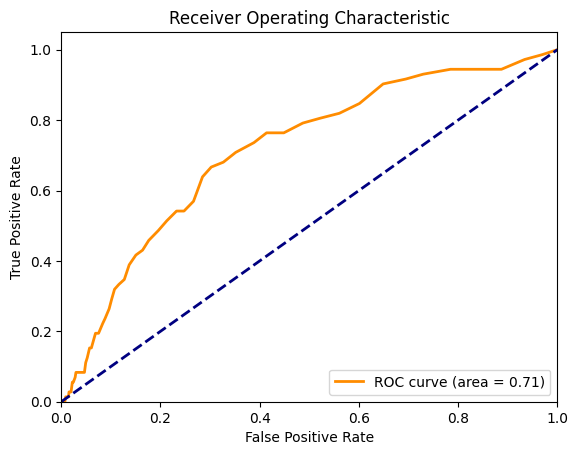

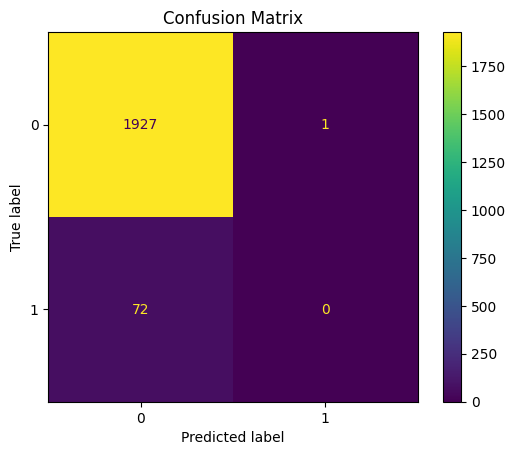

Best parameters found:  {'classifier__n_estimators': 200, 'classifier__max_depth': None}


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
}

# StratifiedKFold setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist,
                                   n_iter=50, cv=cv, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predict probabilities for the test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

print("Best parameters found: ", random_search.best_params_)

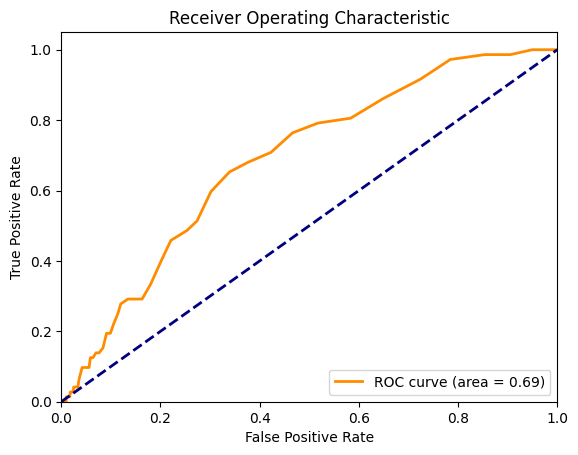

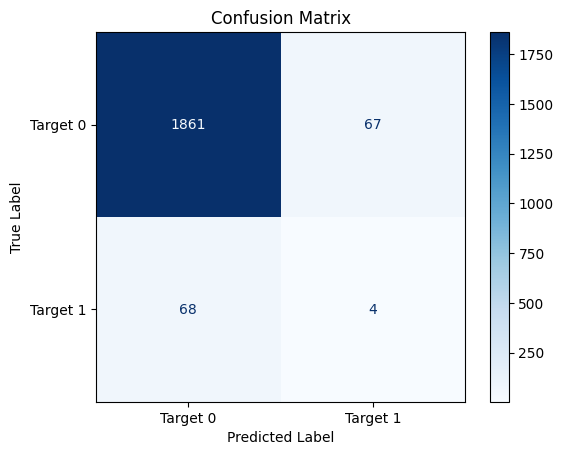

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Assuming X_train, X_test, y_train, and y_test are already defined

# Set up the pipeline with the best parameters
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=None, class_weight={0: 1, 1: 10}, random_state=42))
])

# Train the pipeline on the entire training data
pipeline.fit(X_train, y_train)

# Predict probabilities for the test set
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Adjust the threshold for prediction based on the ROC curve or desired FPR, TPR balance
threshold = 0.2  
y_pred_adjusted = (y_proba > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Target 0', 'Target 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
# Marking null values with a placeholder, for example, -999
# This allows the RandomForest to split on these as a separate category
X = X.fillna(-999)

# Balancing the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform cross-validation
scores = cross_val_score(clf, X_balanced, y_balanced, cv=5)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Output the cross-validation results
print("Cross-validation scores:", scores)
print("Mean CV Accuracy:", scores.mean())

# Output the classification report for test set
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))


Cross-validation scores: [0.91802431 0.99431084 0.99844841 0.97698474 0.999224  ]
Mean CV Accuracy: 0.977398459995042
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1944
           1       1.00      0.97      0.98      1923

    accuracy                           0.98      3867
   macro avg       0.98      0.98      0.98      3867
weighted avg       0.98      0.98      0.98      3867

Accuracy on Test Set: 0.982415309025084


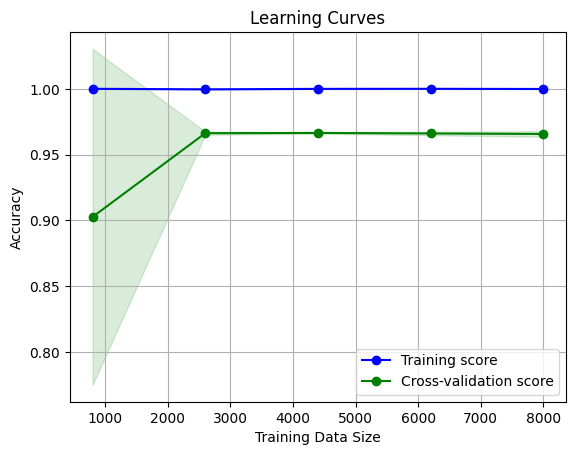

In [23]:
def plot_learning_curves(X, y, estimator, train_sizes):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=5, scoring='accuracy')

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)

    plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green', marker='o')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.15)

    plt.title('Learning Curves')
    plt.xlabel('Training Data Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

#  RandomForestClassifier
model = RandomForestClassifier(random_state=42)
#  train sizes: 10%, 25%, 50%, 75%, 100% of the data
plot_learning_curves(X, y, model, np.linspace(0.1, 1.0, 5))

The RandomForest model exhibits good generalization as evidenced by the improving and converging cross-validation scores with increased training data. The high accuracy across both training and validation sets suggests that the model can handle unseen data well.

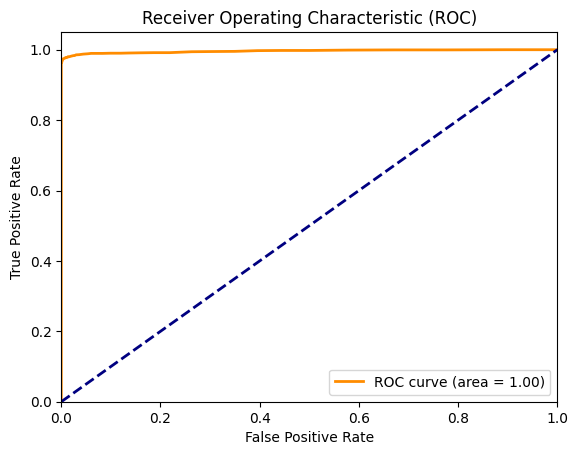

Cross-validation scores: [0.91802431 0.99431084 0.99844841 0.97698474 0.999224  ]
Mean CV Accuracy: 0.977398459995042
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1944
           1       1.00      0.97      0.98      1923

    accuracy                           0.98      3867
   macro avg       0.98      0.98      0.98      3867
weighted avg       0.98      0.98      0.98      3867

Accuracy on Test Set: 0.982415309025084


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Assuming that you've already defined X, y, and imported necessary libraries

# Marking null values with a placeholder
X = X.fillna(-999)

# Balancing the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier with balanced class weights
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform cross-validation
scores = cross_val_score(clf, X_balanced, y_balanced, cv=5)

# Train the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test set - getting probabilities for the positive class
y_scores = clf.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Output the cross-validation results
print("Cross-validation scores:", scores)
print("Mean CV Accuracy:", scores.mean())

# Output the classification report for the test set
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))

 ROC curve area 1.00 might indicate that the model is overfitting the data

## Preprocess and apply PCA for Dimentionality Reduction 

In [25]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA, retain 95% of the variance
pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_scaled)

print("Reduced number of features from 1424 to:", X_pca.shape[1])


Reduced number of features from 1424 to: 102


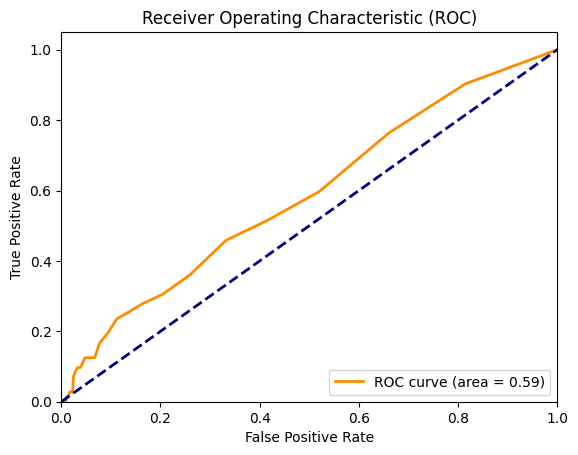

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

An AUC of 0.59 suggests that the model is not performing well in distinguishing between the classes.

## Cross-Validation using StratifiedKFold - good choice to maintain the proportion of classes in each fold, especially with imbalanced data.

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_pca, y, cv=skf, scoring='accuracy')  # Using PCA-transformed data

print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())


Cross-validation scores: [0.965  0.9655 0.9665 0.966  0.9675]
Mean CV accuracy: 0.9661


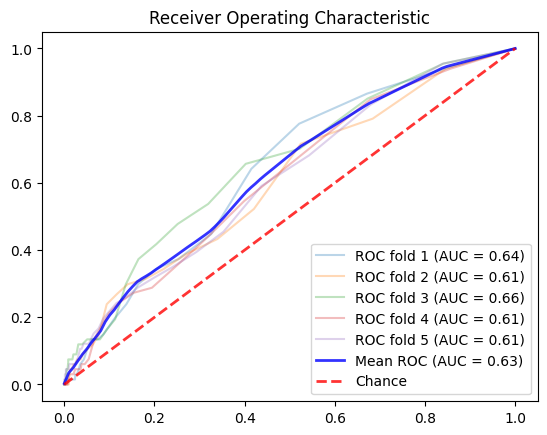

In [34]:
# Standardize features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Initialize RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Prepare StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables to gather results
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X_pca, y)):
    model.fit(X_pca[train], y[train])
    y_scores = model.predict_proba(X_pca[test])[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_scores)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Plotting the ROC curve for each fold
    ax.plot(fpr, tpr, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})', alpha=0.3)

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot mean ROC curve
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)

# Plot diagonal line for reference
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

This increased the Mean Area Under Curve to 63%. ROC fold 3 gave the maximum AUC of 66%.

## RandomForest model with hyperparameter tuning using GridSearchCV 

In [40]:
# Standardize features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model
model = RandomForestClassifier(bootstrap=True, random_state=42)

# Define a parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['log2'],  # Number of features to consider at every split
    'max_depth': [10, 20],  # Maximum number of levels in tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [4]  # Minimum number of samples required at each leaf node
}

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_scaled, y)

# Best model
best_model = grid_search.best_estimator_

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   4.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200

In [41]:
# Predictions
y_pred = best_model.predict(X_test)

# Performance metrics
from sklearn.metrics import classification_report, accuracy_score

# Output the classification report and accuracy
print(classification_report(y_test, y_pred))  # Compare y_test if using a split dataset
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1944
           1       0.00      0.00      0.00      1923

    accuracy                           0.50      3867
   macro avg       0.25      0.50      0.33      3867
weighted avg       0.25      0.50      0.34      3867

Accuracy: 0.5027152831652444


## RandomForest model with hyperparameter tuning using RandomizedSearchCV

In [35]:
# Define the RandomForest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the random grid
param_dist = {
    'n_estimators': [100, 200],
    'max_features': ['log2'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy']
}

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features (optional based on your model's needs)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [37]:
# Fit the random search model
random_search.fit(X_train_scaled, y_train)

# Best model
best_model = random_search.best_estimator_

# Print the best parameters and best score found by RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total 

In [38]:
# Predictions on the test set using the best model
y_pred = best_model.predict(X_test_scaled)

# Performance metrics
print(classification_report(y_test, y_pred))
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1928
           1       0.00      0.00      0.00        72

    accuracy                           0.96      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.93      0.96      0.95      2000

Accuracy on Test Set: 0.964


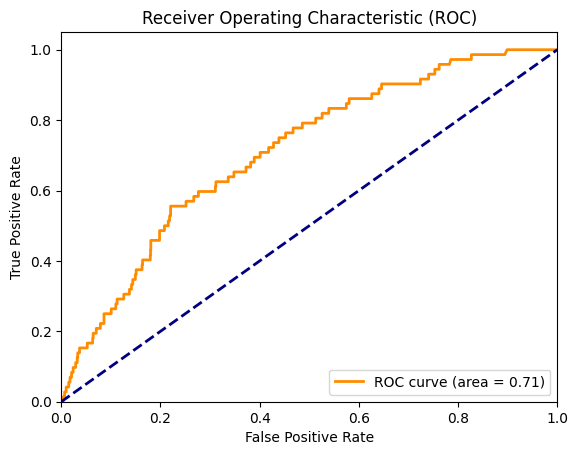

In [39]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming X_test_scaled and y_test are defined, and best_model has been fitted
y_scores = best_model.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)  # Assuming class 1 is the positive class
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


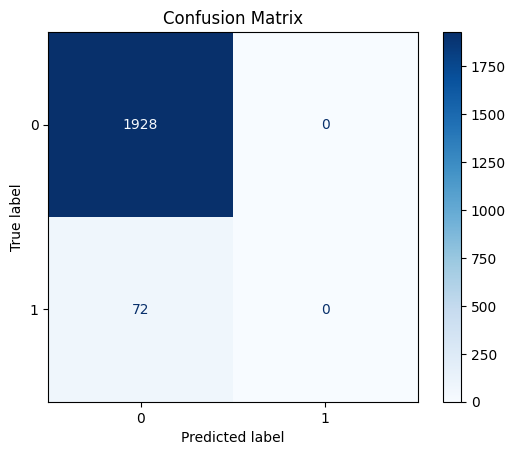

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have y_test and y_pred available from earlier model predictions
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to others such as plt.cm.Greens
plt.title('Confusion Matrix')
plt.show()


## SMOTE and RandomForest with RandomizedSearchCV

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100; total time=   4.7s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100; total time=   4.6s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100; total time=   4.7s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=10, randomfores

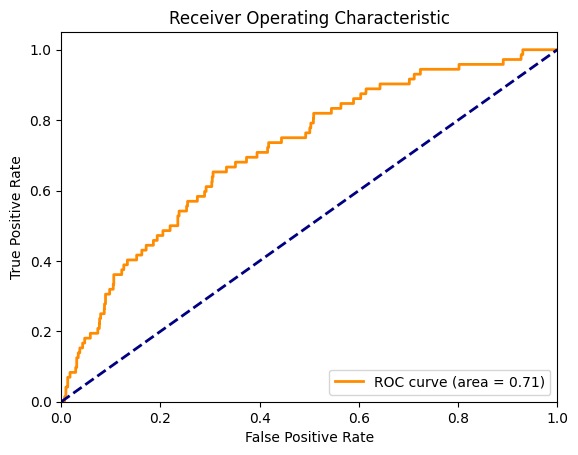

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming X and y are defined and loaded appropriately here

# Load and split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RandomForest model with balanced class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the random grid
param_dist = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['log2'],
    'randomforestclassifier__max_depth': [10, 20],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [2, 4],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

# Create a pipeline with SMOTE and RandomForest
pipeline = make_pipeline_imb(StandardScaler(), SMOTE(random_state=42), model)

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Extract the best estimator
best_model = random_search.best_estimator_

# Predict using the best model
y_pred1 = best_model.predict(X_test)
y_pred_prob1 = best_model.predict_proba(X_test)[:, 1]  # Probabilities needed for ROC

# Evaluate the model
print(classification_report(y_test, y_pred1))
print("Accuracy:", accuracy_score(y_test, y_pred1))
cm = confusion_matrix(y_test, y_pred1)
print(cm)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Update model parameters

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming X and y are defined and loaded appropriately here

# Load and split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RandomForest model with balanced class weights
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the random grid
param_dist = {
    'randomforestclassifier__n_estimators': [200, 300, 400],  # Increased range
    'randomforestclassifier__max_features': ['log2', 'sqrt'],      # Explore different options
    'randomforestclassifier__max_depth': [30, None],       # Including None to allow fully grown trees
    'randomforestclassifier__min_samples_split': [5, 10],       # Higher values
    'randomforestclassifier__min_samples_leaf': [4, 6],         # Higher values
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

# Create a pipeline with SMOTE and RandomForest
pipeline = make_pipeline_imb(StandardScaler(), SMOTE(random_state=42), model)

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Extract the best estimator
best_model = random_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities needed for ROC

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=30, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=200; total time=  10.7s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=30, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=200; total time=  10.1s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=30, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=200; total time=  10.0s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=30, randomfores

## Increase threshold and include balanced weight

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1928
           1       0.00      0.00      0.00        72

    accuracy                           0.96      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.93      0.96      0.95      2000



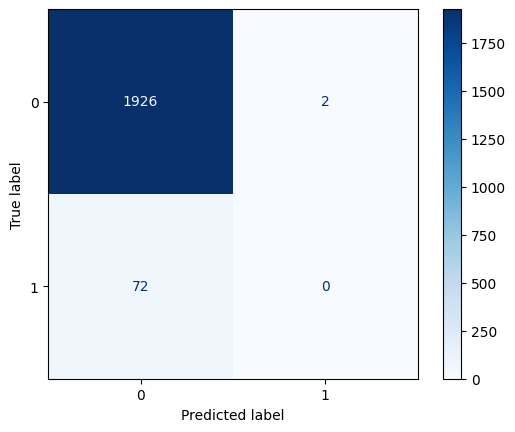

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Adjust class weight
model = RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
probabilities = model.predict_proba(X_test)

# Adjust threshold for the minority class
new_threshold = 0.3  # lower threshold for class 1
predictions = (probabilities[:, 1] >= new_threshold).astype(int)

# Evaluate the new predictions
print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()


##  Gain insights into which features are most influential - This can guide further feature selection.

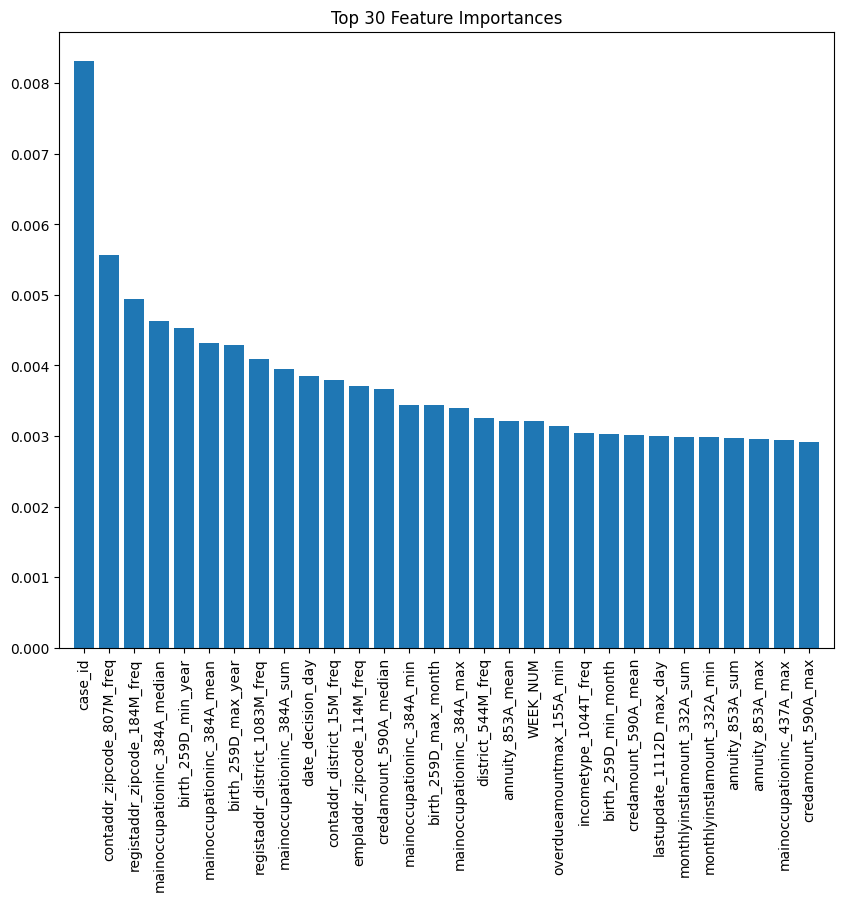

In [26]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X, y)  # Assuming X and y have already been defined

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting only the top 30 features for readability
plt.figure(figsize=(10, 8))
plt.title("Top 30 Feature Importances")
plt.bar(range(30), importances[indices[:30]], align='center')
plt.xticks(range(30), X.columns[indices[:30]], rotation=90)
plt.xlim([-1, 30])
plt.show()
